In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
def clean_data(fname='../edge_data/asoiaf/data/asoiaf-all-edges.csv', num_convos=2):
    '''Takes in a list of character edges and removes 
    any characters who have [num_convos] or less edges in the orginal list'''
    
    df = pd.read_csv(fname)
    df = df[df['Source'].isin(df['Source'].value_counts()[df['Source'].value_counts()>=num_convos].index)]
    df = df[df['Target'].isin(df['Target'].value_counts()[df['Target'].value_counts()>=num_convos].index)]
    return df

In [77]:
path = '../edge_data/asoiaf/data/asoiaf-book{}-edges.csv'
b1_df = clean_data(fname=path.format('1'),num_convos = 0)
b2_df = clean_data(fname=path.format('2'),num_convos = 0)
b3_df = clean_data(fname=path.format('3'),num_convos = 0)
b4_df = clean_data(fname=path.format('4'),num_convos = 0)
b45_df = clean_data(fname=path.format('45'),num_convos = 0)
b5_df = clean_data(fname=path.format('5'),num_convos = 0)
def_edges = clean_data(num_convos = 0)

In [219]:
def edges_from_convos(booknum):
    '''
    Takes a csv list of characters/conversations and makes it a dataframe of weighted edges
    
    Inputs: Book number (does not generalize to abnormally named files)
    Output: Dataframe of character1-character2-weight edges
    '''
    
    b1_convos = pd.read_csv('../data/quotes_book-{}'.format(booknum),index_col = 0)
    convo_edges = b1_convos.groupby(['char1','char2']).count().reset_index()
    convo_edges.columns = ['char1','char2','weight']
    
    return convo_edges

In [220]:
c1,c2,c3,c4,c5 = [edges_from_convos(i) for i in [1,2,3,4,5]]

In [225]:
c5.head()

,char1,char2,weight
0,Aegon,Barristan,4
1,Aegon,Cersei,4
2,Aegon,Chett,1
3,Aegon,Conn,1
4,Aegon,Daenerys,12


In [230]:
def get_egos_for_char(charname):
    graphs = []
    pgr = []
    book = 0
    for d in [c1,c2,c3,c4,c5]:
        book += 1
        G = nx.DiGraph(nx.convert_matrix.from_pandas_dataframe(d, source = "char1", target = "char2"))
        try:
            ego = nx.ego_graph(G, charname, radius = 1)
            graphs.append(ego)
            pgr.append(nx.pagerank(G)[cname])
        except:
            print("{} not in book{}".format(charname, book))
            pass
    return (graphs, pgr)

In [231]:
cname = "Eddard"

In [232]:
def plot_egos(charname):
    egos, scores = get_egos_for_char(charname)
    fig, axes = plt.subplots(2,3,figsize = (15,10))
    for i, ax in enumerate(axes.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        try:
            ax.set_xlabel("Degrees for {}: {}\nPagerank Score:{}".format(cname, nx.degree(egos[i],charname), round(scores[i],3)), fontsize=15)
            nx.draw_networkx(egos[i], with_labels = True, node_size=[400,300,200,200,100][::-1],ax = ax)
        except:
            pass
        

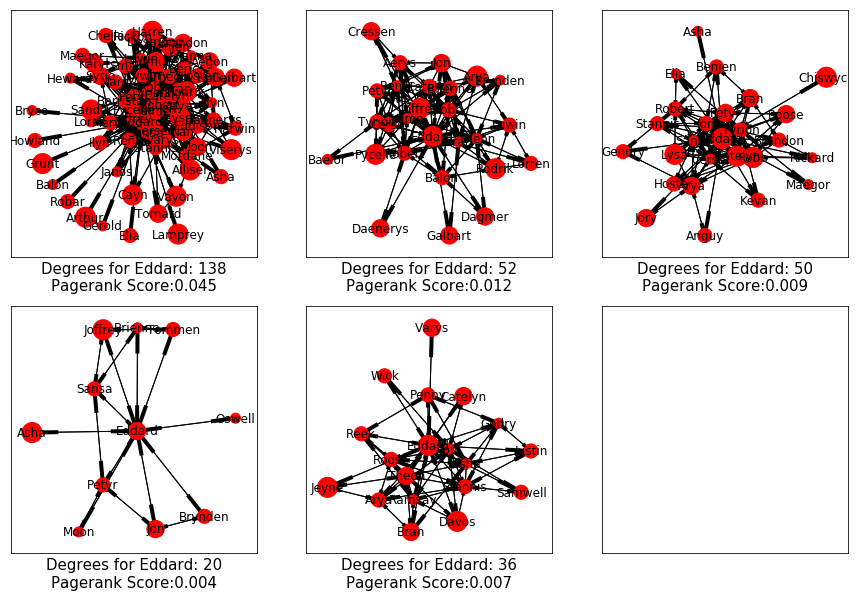

In [233]:
plot_egos(cname)

In [86]:
print(def_edges.shape,"def_edges.shape")

(2823, 5) def_edges.shape


In [87]:
def_edges.loc[def_edges['Source'] == "Aemon-Targaryen-(Dragonknight)"]

,Source,Target,Type,id,weight
41,Aemon-Targaryen-(Dragonknight),Jaime-Lannister,Undirected,41,3


In [88]:
def_edges1 = def_edges.copy()

In [13]:
G = nx.MultiDiGraph(nx.convert_matrix.from_pandas_dataframe(def_edges1, source = "Source", target = "Target"))

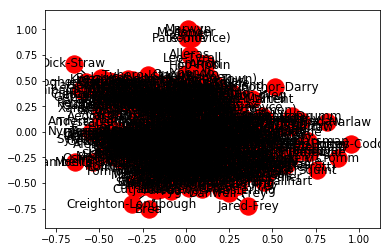

In [14]:
nx.draw_networkx(G)

In [15]:
def get_all_names(df):
    ppl = df['Source'].unique()
    ppl1 = df['Target'].unique()
    ppl = np.append(ppl1, ppl)
    ppl = [i.replace('-','_') for i in ppl]
    ppl = list(set(ppl))
    return ppl

In [16]:
ppl=get_all_names(def_edges)

In [17]:
def get_house_from_wiki(character):
    '''
    Function to scrape a character's house allegiance from the Game of Thrones Wiki
    
    Input:
    character - String: Character name formatted as on the wiki page
    
    Output:
    House (or other organization) allegiance of character
    '''
    
    i = character
    
    if i.endswith('Baratheon'):
        return "House Baratheon"
    elif i.endswith("Targaryen"):
        return "House Targaryen"
    elif i.endswith('Stark'):
        return "House Stark"
    elif i.endswith('Greyjoy'):
        return "House Greyjoy"
    else:
    
        #Get character name in separated list
        char_name = i.split('_')

        #Get page from wiki
        page = requests.get('http://awoiaf.westeros.org/index.php/{}'.format(i))

        #Parse html from page
        soup = BeautifulSoup(page.content, 'html.parser')

        try:
            #Pull table rows out of infobox section of wiki page
            for tr in soup.find('table', class_='infobox infobox-body'):

                #Get only table row for house allegiance
                if tr.text.startswith('Allegiance'):

                    #Drop the word Allegiance and trailing space from start of row
                    allegiances = tr.text[12:].split('[')[0].lstrip("The ")

                    #Find where capital letters occur and get indices
                    #for cases where more than one allegiance is mentioned
                    caps = [i.isupper() for i in allegiances]
                    cap_idx = [j for j, k in (enumerate(caps)) if k == True]

                    #If no allegiance is mentioned on the wiki page, print name and return character surname
                    if allegiances == None:
                        print("No allegiance listed for {}. Attempting to use surname".format(i))
                        return i.split('(')[0].rstrip('_').split('_')[-1]
                    
                    if allegiances.startswith('House Royce'):
                        return 'House Royce'
                    
                    if allegiances.endswith("Kingsguard"):
                        return "Kingsguard"

                    #If only one house or organization is listed    
                    elif len(allegiances.split()) <= 2:
                        if len(cap_idx) == 3:
                            return allegiances[:cap_idx[2]]
                        else:
                            return allegiances

                    elif allegiances.startswith("City Watch"):
                        return "City Watch"

                    else:
                        return ' '.join(allegiances[cap_idx[2]:].split()[:2])
        except:
            #print("No page found for {}. Attempting to use surname.".format(i))
            return i.split('(')[0].rstrip('_').split('_')[-1]

In [18]:
chars_by_houses = [get_house_from_wiki(i) for i in ppl]

In [19]:
list(enumerate(chars_by_houses))

[(0, 'House Greyjoy'),
 (1, 'House Codd'),
 (2, 'House Tyrell'),
 (3, 'House Swyft'),
 (4, "Night's Watch"),
 (5, 'House Frey'),
 (6, 'House Dustin'),
 (7, None),
 (8, 'Dragonstone'),
 (9, 'House Velaryon'),
 (10, 'House Stokeworth'),
 (11, 'House Bolton'),
 (12, 'House Stark'),
 (13, 'House Botley'),
 (14, "Night's Watch"),
 (15, 'House Cassel'),
 (16, 'House of'),
 (17, 'Burned Men'),
 (18, 'Lords Declarant'),
 (19, 'House Clegane'),
 (20, 'House Stark'),
 (21, 'House Lannister'),
 (22, 'Brave Companions'),
 (23, 'City Watch'),
 (24, "Night's Watch"),
 (25, 'House Connington'),
 (26, None),
 (27, 'House Arryn'),
 (28, None),
 (29, 'House Stark'),
 (30, None),
 (31, 'House Lannister'),
 (32, None),
 (33, "Night's Watch"),
 (34, 'House Marbrand'),
 (35, 'Kingsguard'),
 (36, 'Scolera'),
 (37, 'Second Sons'),
 (38, 'House Westerling'),
 (39, None),
 (40, 'House Targaryen'),
 (41, 'House Tyrell'),
 (42, 'House Baratheon'),
 (43, 'Lords Declarant'),
 (44, 'House Karstark'),
 (45, "Night's 

In [20]:
ix = [n for n, v in enumerate(chars_by_houses) if v == None]

In [21]:
missed = [ppl[i] for i in ix]

In [22]:
missed

['Tysha',
 'Cleon',
 'Jarl',
 'Red_Oarsman',
 'Spotted_Cat',
 'Creighton_Longbough',
 'Vyman',
 'Mirri_Maz_Duur',
 'Qarl_the_Maid',
 'Mycah',
 'Ryk',
 'Armen',
 'Gendel',
 'Grigg',
 'Chiggen',
 'Shae',
 'Errok',
 'Joramun',
 'Qavo_Nogarys',
 'Dalla',
 'Illifer',
 'Illyrio_Mopatis',
 'Haggo',
 'Qotho',
 'Scar',
 'Quhuru_Mo',
 'Frenya',
 'Harma',
 'Squirrel',
 'Roone',
 'Cressen',
 'Cromm',
 'Marillion',
 'Narbert',
 'Mollander',
 'Craster',
 'Brea',
 'Gilly',
 'Lommy_Greenhands',
 'Garin_(orphan)',
 'Weeper',
 'Woth',
 'Weasel',
 'Quaro',
 'Rowan',
 'Hizdahr_zo_Loraq',
 'Florian_the_Fool',
 'Hot_Pie',
 'Ghael',
 'Symon_Silver_Tongue',
 'Tormund',
 'Val',
 'Khorane_Sathmantes',
 'Hagen',
 'Toregg',
 'Varamyr',
 'Mag_Mar_Tun_Doh_Weg',
 'Harren_Hoare',
 'Lorren',
 'Holly',
 'Grimtongue',
 'Rattleshirt',
 'Sharna',
 'Xhondo',
 'Marwyn',
 'Drogo',
 'Cutjack',
 'Mance_Rayder',
 'Brusco',
 'Sweets',
 'Big_Boil',
 'Ysilla',
 'Talea',
 'Wun_Weg_Wun_Dar_Wun',
 'Pono',
 'Varys']

In [23]:
c_by_h = dict(zip(ppl, chars_by_houses))

In [24]:
c_by_h

{'Addam_Marbrand': 'House Marbrand',
 'Aegon_Frey_(son_of_Stevron)': 'House Frey',
 'Aegon_I_Targaryen': 'House Targaryen',
 'Aegon_Targaryen_(son_of_Rhaegar)': 'House Targaryen',
 'Aemon_Targaryen_(Maester_Aemon)': 'Targaryen',
 'Aenys_Frey': 'House Frey',
 'Aeron_Greyjoy': 'House Greyjoy',
 'Aerys_II_Targaryen': 'House Targaryen',
 'Aggar': 'House Greyjoy',
 'Aggo': 'House Targaryen',
 'Alayaya': "Chataya's brothel",
 'Albett': "Night's Watch",
 'Alebelly': 'House Stark',
 'Alerie_Hightower': 'House Tyrell',
 'Alester_Florent': 'House Florent',
 'Alla_Tyrell': 'House Tyrell',
 'Allar_Deem': 'City Watch',
 'Allard_Seaworth': 'House Seaworth',
 'Alleras': 'Citadel',
 'Alliser_Thorne': "Night's Watch",
 'Alyn': 'House Stark',
 'Alys_Arryn': 'House Waynwood',
 'Alys_Karstark': 'House Thenn',
 'Alysane_Mormont': 'House Mormont',
 'Amabel': 'House Whent',
 'Amerei_Frey': 'House Lannister',
 'Amory_Lorch': 'House Lannister',
 'Anders_Yronwood': 'House Yronwood',
 'Andrew_Estermont': 'House 

In [25]:
fromlist = []
tolist = []
for c in def_edges['Source']:
    fromlist.append(c_by_h[c.replace('-','_')])
for c in def_edges['Target']:
    try:
        tolist.append(c_by_h[c.replace('-','_')])
    except:
        pass

In [40]:

def_edges['FromHouse'] = fromlist
def_edges['ToHouse'] = tolist

In [27]:
house_csv = def_edges.to_csv('all_edges_with_house')

In [28]:
set(c_by_h.values())

{'House Grafton',
 'Mountain',
 'Mance Rayder',
 'SparrowsFaith Militant',
 'High Hermitage',
 'the Peach',
 'the Thirteen',
 "Alchemists' Guild",
 'YunkaiHouse of',
 'House Tarly',
 "King's Landing",
 'Baratheon of',
 'House Martell',
 'Hghar',
 'Great Masters',
 'Harlaw Hall',
 'House Mallister',
 'UnsulliedHouse ',
 'Stiv',
 'House Lynderly',
 'House Whent',
 'Grazhar',
 'House Bolton',
 'Brightwater Keep',
 "Night's Watch",
 'nn',
 'House Payne',
 'House Rosby',
 'House Clegane',
 'House Florent',
 "SonsIron ShieldsMaiden's",
 "Queen's men",
 'House Hetherspoon',
 'Robin',
 'House StarkHouse',
 'Scolera',
 'FingersHouse Baelish',
 'House Umber',
 'Gendry',
 'Casterly RockHouse',
 'Giant',
 'House Redwyne',
 'Citadel',
 'House Velaryon',
 'Qezza',
 'House Marbrand',
 'House Tyrell',
 'House Piper',
 'House Estermont',
 'Martell',
 'House Baelish',
 'Second Sons',
 'Anguy',
 'Golden Company',
 'House Drumm',
 'BrownhollowHouse Baelish',
 'House Tully',
 'House Mormont',
 'House Black

In [37]:
def in_house_net(df, house_name):
    house_df = df[(df['FromHouse'] == df['ToHouse'])]
    house_df = house_df[house_df['FromHouse'] == house_name]
    return house_df

In [41]:
stark_df = in_house_net(def_edges, 'House Stark')

In [42]:
colors = ['r' if i == "House Stark" else 'b' for i in stark_df['ToHouse']]

In [ ]:
stark_df

In [47]:
def draw_and_score_graph(df):
    G = nx.DiGraph(
                    nx.convert_matrix.from_pandas_dataframe(
                    df, source = "Source", target = "Target"))
    
    #data = json_graph.node_link_data(G)
    #H = json_graph.node_link_graph(data)

    weights = dict(zip(df['weight'], df['weight']))

    nx.set_edge_attributes(G, 'weight', weights.values())
    
    nx.draw_networkx(G)
    degs = nx.degree(G)
    degs = [(degs[node]+1) * 100 for node in G.nodes()]
    
    pos = nx.circular_layout(G)
    
    plt.figure(1, figsize = (20,20))
    #nx.draw(starkG, pos, with_labels = True, node_size = degs)
    
    deg_cent = sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse = True)[:25]
    clo_cent = sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse = True)[:25]
    btw_cent = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse = True)[:25]
    eig_cent = sorted(nx.eigenvector_centrality(G).items(), key=lambda x: x[1], reverse = True)[:25]
    pgr = sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse = True)
    
    most_central = list(set([i[0] for i in deg_cent])|
                             set([i[0] for i in clo_cent])|
                             set([i[0] for i in btw_cent])|
                             set([i[0] for i in eig_cent])|
                             set([i[0] for i in pgr]))[:10]
    
    return (deg_cent[:5], clo_cent[:5], btw_cent[:5], eig_cent[:5], pgr[:5], most_central)

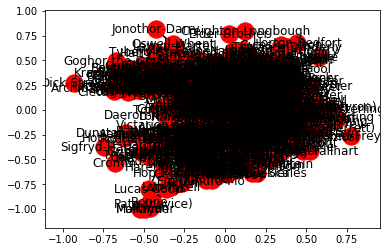

In [48]:
deg, clo, btw, eig, pgr, mo_cen = draw_and_score_graph(def_edges)

In [49]:
pgr

[('Jon-Snow', 0.021000099638346814),
 ('Tyrion-Lannister', 0.01926083333776931),
 ('Jaime-Lannister', 0.015483513454916132),
 ('Cersei-Lannister', 0.014275380814688498),
 ('Stannis-Baratheon', 0.013472750102767755)]

In [50]:

sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse = True)[:10]

[('Jon-Snow', 0.2090235052407737),
 ('Tyrion-Lannister', 0.1618222237081112),
 ('Daenerys-Targaryen', 0.09760586606194271),
 ('Stannis-Baratheon', 0.09622991565902604),
 ('Jaime-Lannister', 0.09569370342852695),
 ('Theon-Greyjoy', 0.09532046763707933),
 ('Cersei-Lannister', 0.0890004559093355),
 ('Robb-Stark', 0.07609258343606788),
 ('Robert-Baratheon', 0.07195991469430654),
 ('Arya-Stark', 0.0691271381325718)]

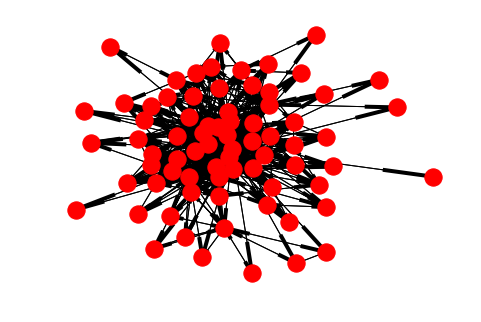

In [125]:
nx.draw(nx.ego_graph(G, 'Sansa-Stark', radius = 1))

In [53]:
list(set(np.append(def_edges['ToHouse'].unique(), def_edges['FromHouse'].unique())))

['House Grafton',
 'Mountain',
 'Mance Rayder',
 'SparrowsFaith Militant',
 'High Hermitage',
 'the Peach',
 'the Thirteen',
 "Alchemists' Guild",
 'YunkaiHouse of',
 'House Tarly',
 "King's Landing",
 'Baratheon of',
 'House Martell',
 'Hghar',
 'Great Masters',
 'Harlaw Hall',
 'UnsulliedHouse ',
 'House Mallister',
 'Stiv',
 'House Lynderly',
 'House Whent',
 'Grazhar',
 'House Bolton',
 'Brightwater Keep',
 "Night's Watch",
 'nn',
 'House Payne',
 'House Rosby',
 'House Clegane',
 "SonsIron ShieldsMaiden's",
 'House Hetherspoon',
 "Queen's men",
 'Robin',
 'House Florent',
 'House StarkHouse',
 'Scolera',
 'FingersHouse Baelish',
 'House Umber',
 'Gendry',
 'Casterly RockHouse',
 'Giant',
 'House Redwyne',
 'Citadel',
 'House Velaryon',
 'Qezza',
 'House Marbrand',
 'House Tyrell',
 'House Estermont',
 'House Piper',
 'Martell',
 'House Baelish',
 'Second Sons',
 'Anguy',
 'Golden Company',
 'House Drumm',
 'BrownhollowHouse Baelish',
 'House Tully',
 'House Mormont',
 'House Waynw

In [54]:
def_edges.columns

Index(['Source', 'Target', 'Type', 'id', 'weight', 'FromHouse', 'ToHouse'], dtype='object')

In [121]:
[n for n in ppl if n.startswith('Val')]

['Val']

In [101]:
first_names = pd.Series([i.split('_')[0] for i in ppl])

In [102]:
first_names

0           Aeron
1           Lucas
2          Olenna
3           Harys
4          Halder
5           Emmon
6         Barbrey
7           Tysha
8         Lamprey
9          Aurane
10         Lollys
11         Yellow
12          Palla
13      Tristifer
14          Bowen
15           Jory
16        Kraznys
17         Timett
18         Symond
19        Tickler
20          Luwin
21         Amerei
22          Biter
23          Allar
24     Stonesnake
25         Ronnet
26          Cleon
27         Vardis
28           Jarl
29        Brandon
          ...    
508         Talea
509           Wun
510         Edric
511        Walder
512        Cersei
513         Roose
514          Pono
515         Mully
516         Daryn
517         Vayon
518       Hallyne
519       Alleras
520        Dagmer
521           Ben
522         Varys
523          Arya
524        Timeon
525        Walder
526       Catelyn
527         Harry
528         Jeyne
529       Skinner
530        Robett
531       Sigfryd
532       

In [105]:
first_names.to_csv('../data/character_first_names.csv')

In [104]:
len(set(first_names))

508

In [60]:
ppl.count('Arya')

0

In [61]:
from collections import Counter
import re

In [62]:
name_dict = Counter(first_names)

In [178]:
[i for i in ppl if i.startswith('Harren')]

['Harren_Hoare']

In [65]:
last_names = [i.split('_') for i in ppl if name_dict[i.split('_')[0]] > 1]

In [67]:
sorted(last_names)

[['Aegon', 'Frey', '(son', 'of', 'Stevron)'],
 ['Aegon', 'I', 'Targaryen'],
 ['Aegon', 'Targaryen', '(son', 'of', 'Rhaegar)'],
 ['Alys', 'Arryn'],
 ['Alys', 'Karstark'],
 ['Baelor', 'Blacktyde'],
 ['Baelor', 'I', 'Targaryen'],
 ['Balon', 'Greyjoy'],
 ['Balon', 'Swann'],
 ['Ben', 'Bones'],
 ['Ben', 'Plumm'],
 ['Brandon', 'Norrey'],
 ['Brandon', 'Stark'],
 ['Dick', 'Crabb'],
 ['Dick', 'Follard'],
 ['Dick', 'Straw'],
 ['Emmon', 'Cuy'],
 ['Emmon', 'Frey'],
 ['Gerold', 'Dayne'],
 ['Gerold', 'Hightower'],
 ['Gyles', 'Grafton'],
 ['Gyles', 'Rosby'],
 ['High', 'Septon', '(Tyrions)'],
 ['High', 'Septon', '(fat', 'one)'],
 ['High', 'Sparrow'],
 ['Jeyne', 'Poole'],
 ['Jeyne', 'Westerling'],
 ['Jon', 'Arryn'],
 ['Jon', 'Connington'],
 ['Jon', 'Snow'],
 ['Jon', 'Umber', '(Greatjon)'],
 ['Narbert'],
 ['Narbert', 'Grandison'],
 ['Oswell', 'Kettleblack'],
 ['Oswell', 'Whent'],
 ['Petyr', 'Baelish'],
 ['Petyr', 'Frey'],
 ['Rickard', 'Karstark'],
 ['Rickard', 'Stark'],
 ['Robert', 'Arryn'],
 ['Robert', 

In [70]:
l_name_test = ' '.join([i[1] if len(i)>1 else i[0] for i in last_names])

In [71]:
l_name_test

'Frey Stark Karstark Follard Strong Norrey Straw Greyjoy Karstark Harlaw Frey Kettleblack Frey Poole Snow Septon Umber Ryger Frey Blacktyde Narbert Grandison Stark Septon Arryn Plumm Grafton Hightower Stark Rosby Whent Arryn Sparrow Targaryen I Swann Dayne Cassel Flint Connington Baelish Crabb Arryn I Rivers Karstark Cuy Frey Bones Frey Westerling Baratheon'

In [72]:
name_test_idx = [i.start() for i in re.finditer('Arryn',l_name_test)]

In [73]:
idx_test = [10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]

### Sentences as nodes, check for shortest path from convo to name sentence
#### Assign node attributes as convo, char (Charname?), or none
#### Ego graph for each convo node, find nearest char/charname nodes

In [74]:
name_test_idx

[170, 218, 294]

In [89]:
z_df = pd.DataFrame({'from':['jon','bob','tom','frank','jim'], 'to':['tom','tom','jon','frank','frank'],'house':['1','2','3','3','1']})

In [179]:
z_df

,from,house,to
0,jon,1,tom
1,bob,2,tom
2,tom,3,jon
3,frank,3,frank
4,jim,1,frank


In [236]:
with open('../data/005ssb.txt', encoding = 'windows-1252') as f:
    book_5 = f.read()

In [237]:
book_5.find('Eddard')

131383

In [242]:
list(re.finditer(r'Eddard(.*)Reek', book_5))

[<_sre.SRE_Match object; span=(1002119, 1002205), match='Eddards little girl, they say," Stouts cook compl>]

In [239]:
c5[(c5['char1'] == 'Eddard')|(c5['char2'] == 'Eddard')]

,char1,char2,weight
104,Arya,Eddard,1
130,Asha,Eddard,2
274,Bran,Eddard,10
308,Catelyn,Eddard,1
524,Davos,Eddard,1
584,Eddard,Godry,1
585,Eddard,Jeyne,1
586,Eddard,Jon,8
587,Eddard,Justin,3
588,Eddard,Penny,2


In [249]:
book_5[937100:937600]

' the boy." \n"Roose Bolton has Lord Eddards daughter. To thwart him White Harbor must have Neds son  \nand the direwolf. The wolf will prove the boy is who we say he is, should the Dreadfort attempt to deny \nhim. That is my price, Lord Davos. Smuggle me back my liege lord, and I will take Stannis Baratheon as \nmy king." \nOld instinct made Davos Seaworth reach for his throat. His fingerbones had been his luck, and \nsomehow he felt he would have need of luck to do what Wyman Manderly was asking of h'

In [247]:
book_5.find('Smuggle me back my liege lord')

937341